## Testing σ-irregularity vs. total σ-irregularity

### Problem Definition
We are given two measures of a graph irregularity,
*σ-irregularity* and *total σ-irregularity*, defined as bellow:<br /><br />
$$
\sigma(G) = \sum_{(u,v) \in E(G)}(d(u) - d(v))^2 
\quad\text{and}\quad 
\sigma_t(G) = \sum_{(u,v) \in V(G)}(d(u) - d(v))^2
$$.
We are searching for graphs, where the ratio's
$r_{\sigma} = \sigma_t(G)\thinspace/\thinspace\sigma(G)$ 
maximum is reached.

### Basic Environment Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

from math import inf

NNODES = 25
NSIMUL = 200
NTESTS = 100

### Solution Implementation

We will use simulated annealing algorithm to attack this problem and have written a library that will help us with the general implementation. 
The main idea was using the algorithm to find a global optimum (the graph that maximizes $\sigma_r$) by making global changes at every step and then fix the acquired graph by fixing it with some mild local changes.

Lets try running the algorithm on 20 nodes with 200 simulations made and by choosing a *globalBasicNeighbor* topology, which defines the neighbor pretty much as a random connected graph on 20 vertices.

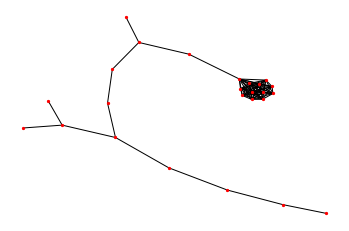

Sigma Ratio: 103.796875


In [8]:
from pylib import (
    maxSigmaRatio_annealing, globalBasicNeighbor,
    simplePlot, neighborListToNx
)

g, r = maxSigmaRatio_annealing(
    NNODES, 100, NSIMUL, globalBasicNeighbor
)

simplePlot(neighborListToNx(g))
print('Sigma Ratio:', r)

We noticed a pattern here early on, which is the two-parted nature of optimal graphs, so we adjusted the neighborhood topology for optimization purposes. Lets try out another topology.

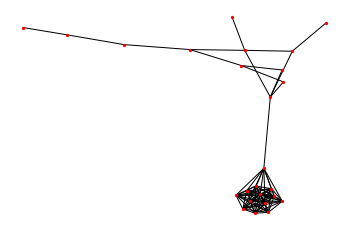

Sigma Ratio: 102.17460317460318


In [3]:
from pylib import globalTwoPartNeighbor

g, r = maxSigmaRatio_annealing(
    NNODES, 100, NSIMUL, globalTwoPartNeighbor
)

simplePlot(neighborListToNx(g))
print('Sigma Ratio:', r)

Now we've covered the global part, but we still can find a slightly better optimum, by applying some local changes, like trying to smooth the difference between the degree of nodes forming a bridge between a full subgraph and the tree-like subgraph. This is implemented in the function *localBasicNeighbor*.

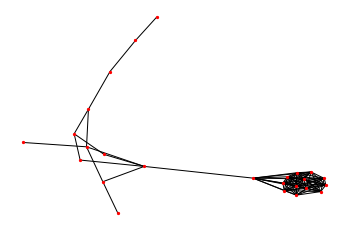

Sigma Ratio: 102.17460317460318


In [4]:
from pylib import localBasicNeighbor

g, r = maxSigmaRatio_annealing(
    NNODES, 100, NSIMUL, localBasicNeighbor,
    defaultG = g
)

simplePlot(neighborListToNx(g))
print('Sigma Ratio:', r)

The next step is to see how the optimal graph's $\sigma_r$ value progresses when its order rises.
We will graph the resulting $\sigma_r$ values using *matplotlib* as we did before implicitly.
But first lets gather the data.

In [5]:
nsim_global, nsim_local = NSIMUL, 20
index, ascend = [], []
_range = range(3, NTESTS)
for i in _range:
    startedges = i * (i - 1) // 2
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_global,
        globalTwoPartNeighbor
    )
    g, r = maxSigmaRatio_annealing(
        i, startedges, nsim_local,
        localBasicNeighbor
    )
    ascend.append(r)

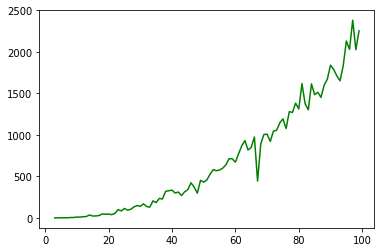

In [6]:
import matplotlib.pyplot as plt

plt.plot(_range, ascend, 'g')
plt.show()

We now have some sense of what is happening with the $\sigma_r$ values, but our task is also to find real values $c$ and $p$ for which $cn^p$ best aproximates $\sigma_r(G_n)$. 
We will implement this using the *largest squares method*, which for given $p$ lets us find the best aproximation $c$ explicitly.

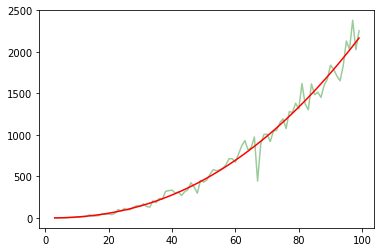

Optimal power: 2.27
Optimal constant: 0.06397400557630922
Optimal difference: 843.1692076792593


In [7]:
from pylib import squares

opt_diff, opt_c, opt_p = inf, 0, 0
for p in (i / 100 for i in range(400)):
    x = [pow(i, p) for i in _range]
    c, d = squares(x, ascend)
    if d < opt_diff:
        opt_diff, opt_c, opt_p = d, c, p

plt.plot(_range, ascend, 'g', alpha=0.4)
plt.plot(_range, [opt_c * pow(i, opt_p) for i in _range], 'r')
plt.show()

print('Optimal power:', opt_p)
print('Optimal constant:', opt_c)
print('Optimal difference:', opt_diff)